# Guidelines

This notebook is a template of what could be explored. You can follow it or explore and experiment additional things.

Use the notebook to add your comments, figures, .... You can remove and reorganize it as you wish. The goal is for you to make a nice report. The important points are to: 
- understand what you will write
- explain the experimental results
- the code should be clean and well documented
- when copy many times the same code, take the time to create a function instead. 

# ResNet (simplified) on CIFAR10 

ResNet is a famous architecture and still state of the art for image classification and object detection. The 
[original ResNet paper](https://arxiv.org/abs/1512.03385) describes the principles and you will find below an overview. 

The dataset is [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html). This dataset gathers images in colors. To plot the images look at the end of the second lab session on convolution (the notebook). CIFAR10 image classification dataset consists of 50k training  images and 10k testing images in 10 classes. The network inputs are $32\times 32$ images, with the per-pixel mean subtracted. 

## ResNet models 

ResNet relies on what we call ResNet blocks. A ResNet block is typically a convolutional block with a residual connection. A major obstacle in training deeper neural networks is the well-known  vanishing gradien problem: as  layers are added to the network the 
multiplying gradients during the backward pass yields very small gradients for the first layers (more or less like noise).

The ResNet architecture is an attempt to tackle this strong issue. Let start by the definition of a Residual block: 

<img align="center" src="https://drive.google.com/uc?id=1c4QvJN4H_GdGWNM-vW46j_JIG64CD_mD" />

In the previous figure, the input is $X$ and the output is $\mathcal{F}(X)+X$ followed by a Relu. $\mathcal{F}$ is a convolutional block. 
The residual block have some nice properties for the gradient backpropagation (see the course). A cascade of these residual blocks is used 
to create very deep CNN models with more than 100 
layers as presented in the original ResNet paper. 

The authors of the original paper train and test six different ResNet architectures on CIFAR10 and 
compare the results. 
The tested depth are $20,32,44,56,110$. Here are the results: 


| MODEL | %error   | 
|------|------|
|   ResNet-20  | 8.75|
|   ResNet-32  |7.51 |
|   ResNet-44  |7.17|
|   ResNet-56  |6.97 |
|   ResNet-110  | 6.43|



# A simplified ResNet model

In this lab, your goal is to implement a ResNet like architecture (we will simplify a little the architecture). 

## The input parts 
The first layers are quite regular: 
- The images are fed to a convolutional network (input_channels = 3, output_channels=16, kernel_size=3, stride=1, padding=1, bias=False) followed by a relu activation. 
- Then we will apply a batch normalization. 

## A cascade of residual blocks
To define a residual block, let us first define $\mathcal{F}$: 
- A first convolution (in_channels = out_channels = 16, kernel_size=3, stride=1, padding=1, bias=False) followed by a Relu. 
- And Batch Norm. 
- Then we add another convolution layer (with the same hyperparameters) followed by a Relu and another BatchNorm. 

The output of the residual block includes the residual connection : 
$out = relu(x + \mathcal{F}(x))$$ 

## Classification
At the end of this cascade, we can add a final Linear layer to make the classification. 

## Implementation 
A good idea is to first define a class *BasicBlock* as a pytorch *Module*. This block implements $\mathcal{F}$ as described before. 
Then you can implement a class ResNet that includes the different parts previouly described: 
- input parts
- a list of *BasicBlock* (the number **n** of these blocks should be a parameter of the constructor)
- the output classifier. 

# TODO 
Implement a ResNet classifier on CIFAR10. 

- Starts with $n=2$ residual blocks
- Find an adapted learning rate by testing different values. 
- Then Increase $n$ to 5, 10 and 20. 
- For high $n$, run the code on Colab using GPUs. For that purpose all the Tensors used during training and valid, along with the models should be transfered on GPU (see the course). 



In [ ]:
#usefull imports
# math, numpy and plot
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt 
# torch 
import torch as th
import torch.autograd as autograd
import torch.nn.functional as F
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
# gzip 
import gzip
import pickle


In [ ]:
train_on_gpu = th.cuda.is_available()
if not train_on_gpu:
  print('CUDA is not available.')
else:
  print('CUDA is available')

CUDA is available


##Loading Data

In [ ]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),     
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batchs = 200

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

trainloader = th.utils.data.DataLoader(trainset, batch_size=batchs,
                                      shuffle=True, num_workers=2, pin_memory=True)
testloader = th.utils.data.DataLoader(testset, batch_size=batchs,
                                      shuffle=True, num_workers=2, pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


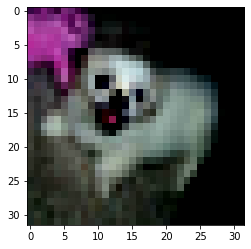

(torch.Size([3, 32, 32]), torch.float32)

In [ ]:
#Trying to see a random image and looking for the shape of the image
img, label = trainset[7000]
img, label
plt.imshow(img.permute(1, 2, 0)) #We have to use permute to change the order of the axes from C × H × W to H × W × C to match what Matplotlib expects.
plt.show()
img.shape, img.dtype

#We can notice that we have a 32 x 32 x 3 image, since we are in RGB and we have 3 channels 

# One convolution layer
As a first step, we are going to run a model with only one convolutional layer and a maxpool.

In [ ]:
#Basic class for a simple Neural Network with only one convolution layer
class CNN(nn.Module):
    def __init__(self, kernel_size = 3, padding= 1, out_channels = 16):
        super(CNN, self).__init__()
        self.layer1 = nn.Conv2d(in_channels=3, out_channels=out_channels, 
                              kernel_size=kernel_size, padding=padding)
        self.layer2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer3 = nn.Linear(16*16*out_channels, 10)
        self.layer4 = nn.LogSoftmax(dim=1)

        
    def forward(self, x):
        out  = self.layer1(x)
        out =  F.relu(out)
        out = self.layer2(out)
        out = out.view(x.size(0), -1) 
        out = self.layer3(out)
        out = self.layer4(out)
        return out


In [ ]:
def train(model, optimizer, loss_fn, trainloader, valloader, epochs=30, verbose=False):
    # The verbose allows you to skip printed information per epoch.
    # The function will only print the best accuracy on the validation
    # and plot the learning curves. 
    
    loss_train = []
    loss_val = []
    accuracy = []

    for epoch in range(epochs):
      #Train
      loss_train_epoch = 0
      loss_val_epoch = 0
      accuracy_epoch = 0

      model.train()
      for i, (images, labels) in enumerate(trainloader):
        images, labels = images.cuda(), labels.cuda()

        logsoftmax = model(images)
        loss_t = loss_fn(logsoftmax, labels)

        #Here we sum the error of each batch and then use the total error of the epoch
        loss_train_epoch += loss_t.item()/len(images)
        
        optimizer.zero_grad() #Set all gradients to zero (not cumulative)
        loss_t.backward() #Propagate the error (back propagation)
        optimizer.step() #Update the Ws

        th.cuda.empty_cache()

      loss_train.append(loss_train_epoch)

      #Validation
      model.eval()
      with th.no_grad():
        for i, (images, label) in enumerate(valloader):
          images, label = images.cuda(), label.cuda()

          logsoftmax = model(images)
          loss_v = loss_fn(logsoftmax, label) 
          loss_val_epoch += loss_v.item()     

          #Calculating the accuracy of the model for each epoch
          #It returns all elements that p = 1 and their index
          prob_predict, class_predict = logsoftmax.topk(1)
          acc = (class_predict.T == label).sum().float()
          accuracy_epoch += acc

      accuracy_epoch = accuracy_epoch/100
      loss_val.append(loss_val_epoch)
      accuracy.append(accuracy_epoch)
      
      # if verbose:
      print(f'Epoch: {epoch}\tTrain loss: {loss_train_epoch}\tAccuracy validation: {accuracy_epoch}')

    return loss_train, loss_val, accuracy, logsoftmax

In [ ]:
loss = nn.NLLLoss()
model = CNN()
model = model.cuda()
optimizer=th.optim.Adam(model.parameters(),lr=0.0001)

In [ ]:
loss_train_sigmoid, loss_val_sigmoid, accuracy_sigmoid, softmax = train(model, optimizer, loss, trainloader, testloader, epochs = 10)

Epoch: 0	Train loss: 1.9622927492856983	Accuracy validation: 53.02000045776367
Epoch: 1	Train loss: 1.5943379515409477	Accuracy validation: 55.939998626708984
Epoch: 2	Train loss: 1.4874830719828602	Accuracy validation: 58.5099983215332
Epoch: 3	Train loss: 1.4101204803586014	Accuracy validation: 58.25
Epoch: 4	Train loss: 1.3484239324927334	Accuracy validation: 61.209999084472656
Epoch: 5	Train loss: 1.3080057013034823	Accuracy validation: 61.57999801635742
Epoch: 6	Train loss: 1.2729919382929802	Accuracy validation: 62.25
Epoch: 7	Train loss: 1.2408328059315685	Accuracy validation: 62.8599967956543
Epoch: 8	Train loss: 1.218797652423381	Accuracy validation: 62.5
Epoch: 9	Train loss: 1.1936714848876002	Accuracy validation: 62.81999969482422


In [ ]:
print(max(accuracy_sigmoid), accuracy_sigmoid[-1])

tensor(62.8600, device='cuda:0') tensor(62.8200, device='cuda:0')


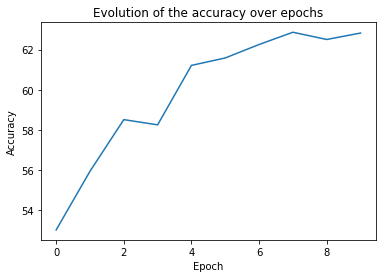

In [ ]:
plt.plot(np.arange(10), th.tensor(accuracy_sigmoid))
plt.title('Evolution of the accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

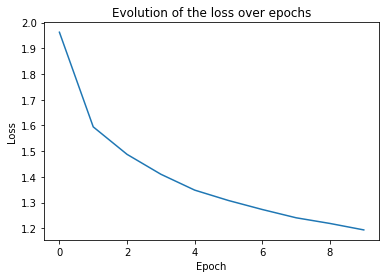

In [ ]:
plt.plot(np.arange(10), loss_train_sigmoid)
plt.title('Evolution of the loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# ResNET with two residual block
Now we are implementing a ResNET with only two residual block

In [ ]:
#Basic class for a simple Neural Network with only one convolution layer

class ResidualBlock(nn.Module):
  def __init__(self, kernel_size = 3, padding = 1, out_channels = 16):
    super(ResidualBlock, self).__init__()
    self.block = nn.Sequential(
        nn.Conv2d(in_channels = out_channels, out_channels=out_channels, 
                  kernel_size = kernel_size, padding = padding),
        nn.ReLU(),
        nn.BatchNorm2d(out_channels),

        nn.Conv2d(in_channels = out_channels, out_channels=out_channels, 
                  kernel_size = kernel_size, padding = padding),
        nn.ReLU(),
        nn.BatchNorm2d(out_channels),
    )

class CNNResNet(nn.Module):
    def __init__(self, kernel_size = 3, padding= 1, out_channels = 16, n_blocks = 2):
        super(CNNResNet, self).__init__()

        self.n_blocks = n_blocks

        block_class = ResidualBlock()
        basicblock = getattr(block_class, 'block')

        self.convlayer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=out_channels, 
                              kernel_size=kernel_size, padding=padding),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),

            nn.Conv2d(in_channels = out_channels, out_channels=out_channels, 
                  kernel_size = kernel_size, padding = padding),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
        )

        for i in range(2, self.n_blocks + 1):
          setattr(self, f'convlayer{i}', basicblock)          
        
        self.linearlayer = nn.Linear(32*32*out_channels, 10)

        
    def forward(self, x):

        #Creating a list of outputs that will be used for higher numbers of residual blocks
        list_outputs = []
        out_block1 = self.convlayer1(x)
        list_outputs.append(out_block1)
        out_block2 = self.convlayer2(out_block1) + out_block1
        list_outputs.append(out_block2)     

        #A list of all convlayers disponibles
        list_name_layers = [attribute for attribute in dir(self) if 'convlayer' in attribute]
        list_layers = [getattr(self, layer_name) for layer_name in list_name_layers]

        for layer in list_layers[2:]:
          #Since we are using a list of outputs, it's usefull to know that, in our case,
          #we are going to use always the n-1 and n-2 as inputs for our next block
          out_block = layer(list_outputs[-1]) + list_outputs[-2]
          list_outputs.append(out_block)

        #Here we get the last output to make a transform in the view and generate our probability
        out = list_outputs[-1].view(list_outputs[-1].size(0), -1)

        out = self.linearlayer(out)
        out = F.log_softmax(out, dim=1)
        return out



In [ ]:
loss = nn.NLLLoss()
model = CNNResNet()
model = model.cuda()
optimizer=th.optim.Adam(model.parameters(),lr=0.00001)

In [ ]:
th.cuda.empty_cache()
loss_train_sigmoid_conv2, loss_val_sigmoid_conv2, accuracy_sigmoid_conv2, softmax_conv2 = train(model, optimizer, loss, trainloader, testloader, epochs = 10, verbose=True)

Epoch: 0	Train loss: 2.443185084462166	Accuracy validation: 37.779998779296875
Epoch: 1	Train loss: 2.0571093696355813	Accuracy validation: 43.0099983215332
Epoch: 2	Train loss: 1.9012243402004239	Accuracy validation: 45.849998474121094
Epoch: 3	Train loss: 1.8033127212524422	Accuracy validation: 47.73999786376953
Epoch: 4	Train loss: 1.7306943327188484	Accuracy validation: 48.78999710083008
Epoch: 5	Train loss: 1.6736591631174074	Accuracy validation: 50.62999725341797
Epoch: 6	Train loss: 1.6263296204805366	Accuracy validation: 51.2599983215332
Epoch: 7	Train loss: 1.585592324733735	Accuracy validation: 52.14999771118164
Epoch: 8	Train loss: 1.5473414558172214	Accuracy validation: 53.03999710083008
Epoch: 9	Train loss: 1.5153054064512255	Accuracy validation: 53.90999984741211


In [ ]:
print(max(accuracy_sigmoid_conv2), accuracy_sigmoid_conv2[-1])

tensor(53.9100, device='cuda:0') tensor(53.9100, device='cuda:0')


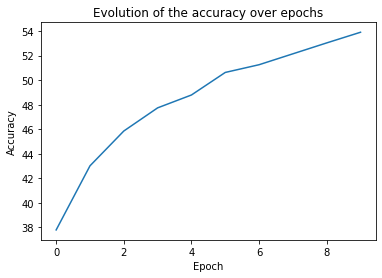

In [ ]:
plt.plot(np.arange(10), th.tensor(accuracy_sigmoid_conv2))
plt.title('Evolution of the accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

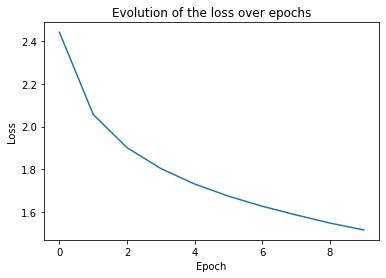

In [ ]:
plt.plot(np.arange(10), loss_train_sigmoid_conv2)
plt.title('Evolution of the loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

#N = 5
Now we are going to try it with 5 residual blocks

In [ ]:
loss = nn.NLLLoss()
model = CNNResNet(n_blocks = 5)
model = model.cuda()
optimizer=th.optim.Adam(model.parameters(),lr=0.0001)

In [ ]:
loss_train_sigmoid_conv5, loss_val_sigmoid_conv5, accuracy_sigmoid_conv5, softmax_conv5 = train(model, optimizer, loss, trainloader, testloader, epochs = 10, verbose=True)

Epoch: 0	Train loss: 2.1238449913263326	Accuracy validation: 45.40999984741211
Epoch: 1	Train loss: 1.5687611299753186	Accuracy validation: 48.37999725341797
Epoch: 2	Train loss: 1.3348743906617169	Accuracy validation: 49.65999984741211
Epoch: 3	Train loss: 1.1710156363248836	Accuracy validation: 50.45000076293945
Epoch: 4	Train loss: 1.0335891944170004	Accuracy validation: 51.29999923706055
Epoch: 5	Train loss: 0.9263173002004622	Accuracy validation: 51.38999938964844
Epoch: 6	Train loss: 0.8272987195849417	Accuracy validation: 51.36000061035156
Epoch: 7	Train loss: 0.7465879264473916	Accuracy validation: 50.96999740600586
Epoch: 8	Train loss: 0.6714053153991697	Accuracy validation: 51.18000030517578
Epoch: 9	Train loss: 0.6049738676846022	Accuracy validation: 51.62999725341797


In [ ]:
print(max(accuracy_sigmoid_conv5), accuracy_sigmoid_conv5[-1])

tensor(51.6300, device='cuda:0') tensor(51.6300, device='cuda:0')


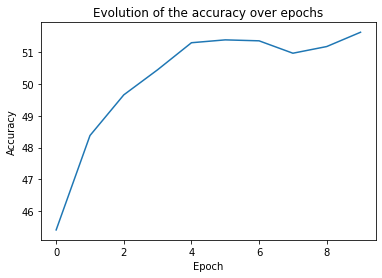

In [ ]:
plt.plot(np.arange(10), th.tensor(accuracy_sigmoid_conv5))
plt.title('Evolution of the accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

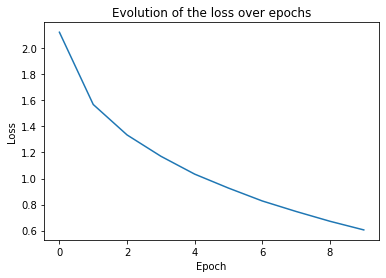

In [ ]:
plt.plot(np.arange(10), loss_train_sigmoid_conv5)
plt.title('Evolution of the loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

#N = 10
Now we're going to try it with 10 blocks

In [ ]:
loss = nn.NLLLoss()
model = CNNResNet(n_blocks = 10)
model = model.cuda()
optimizer=th.optim.Adam(model.parameters(),lr=0.0001)

In [ ]:
loss_train_sigmoid_conv10, loss_val_sigmoid_conv10, accuracy_sigmoid_conv10, softmax_conv10 = train(model, optimizer, loss, trainloader, testloader, epochs = 30, verbose=True)

Epoch: 0	Train loss: 2.9191797602176695	Accuracy validation: 26.329999923706055
Epoch: 1	Train loss: 1.8499495190382005	Accuracy validation: 26.5
Epoch: 2	Train loss: 1.4702158793807034	Accuracy validation: 27.68000030517578
Epoch: 3	Train loss: 1.2320612403750422	Accuracy validation: 28.079999923706055
Epoch: 4	Train loss: 1.059237667322159	Accuracy validation: 27.989999771118164
Epoch: 5	Train loss: 0.913309940993786	Accuracy validation: 28.219999313354492
Epoch: 6	Train loss: 0.799351951926947	Accuracy validation: 29.84000015258789
Epoch: 7	Train loss: 0.7066214035451414	Accuracy validation: 28.149999618530273
Epoch: 8	Train loss: 0.6208650201559066	Accuracy validation: 27.469999313354492
Epoch: 9	Train loss: 0.5490149675309663	Accuracy validation: 29.44999885559082
Epoch: 10	Train loss: 0.48650386109948174	Accuracy validation: 28.989999771118164
Epoch: 11	Train loss: 0.4296271245926621	Accuracy validation: 28.389999389648438
Epoch: 12	Train loss: 0.3882712026685477	Accuracy validat

In [ ]:
print(max(accuracy_sigmoid_conv10), accuracy_sigmoid_conv10[-1])

tensor(42.6800, device='cuda:0') tensor(42.6800, device='cuda:0')


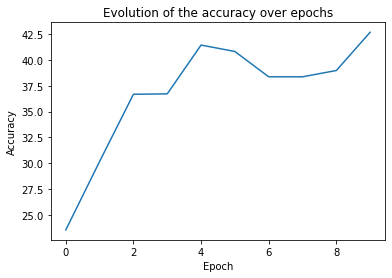

In [ ]:
plt.plot(np.arange(10), th.tensor(accuracy_sigmoid_conv10))
plt.title('Evolution of the accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

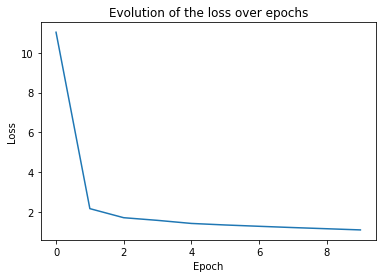

In [ ]:
plt.plot(np.arange(10), loss_train_sigmoid_conv10)
plt.title('Evolution of the loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

#N = 20
Now we are trying a ResNET with 20 residual blocks

In [ ]:
loss = nn.NLLLoss()
model = CNNResNet(n_blocks = 20)
model = model.cuda()
optimizer=th.optim.Adam(model.parameters(),lr=0.0001)

In [ ]:
loss_train_sigmoid_conv20, loss_val_sigmoid_conv20, accuracy_sigmoid_conv20, softmax_conv20 = train(model, optimizer, loss, trainloader, testloader, epochs = 10, verbose=True)

Epoch: 0	Train loss: 56.47377371788025	Accuracy validation: 9.649999618530273
Epoch: 1	Train loss: 51.34479796886444	Accuracy validation: 15.389999389648438
Epoch: 2	Train loss: 48.73628807067871	Accuracy validation: 19.389999389648438
Epoch: 3	Train loss: 46.89328610897064	Accuracy validation: 21.40999984741211
Epoch: 4	Train loss: 45.43682944774628	Accuracy validation: 23.19999885559082
Epoch: 5	Train loss: 44.310805678367615	Accuracy validation: 22.739999771118164
Epoch: 6	Train loss: 43.12908339500427	Accuracy validation: 22.90999984741211
Epoch: 7	Train loss: 42.36884951591492	Accuracy validation: 23.53999900817871
Epoch: 8	Train loss: 41.48024272918701	Accuracy validation: 22.6299991607666
Epoch: 9	Train loss: 40.775006890296936	Accuracy validation: 23.78999900817871


In [ ]:
print(max(accuracy_sigmoid_conv20), accuracy_sigmoid_conv20[-1])

tensor(23.7900, device='cuda:0') tensor(23.7900, device='cuda:0')


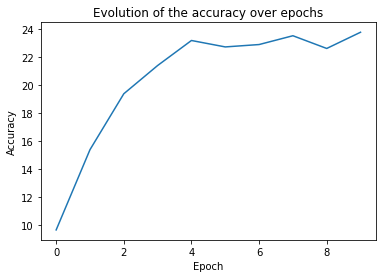

In [ ]:
plt.plot(np.arange(10), th.tensor(accuracy_sigmoid_conv20))
plt.title('Evolution of the accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

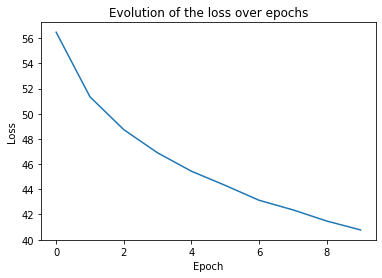

In [ ]:
plt.plot(np.arange(10), loss_train_sigmoid_conv20)
plt.title('Evolution of the loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

#Extra: State-of-the-art performance
Let's implement a simple ResNET, with only two blocks, but changing the output channels size, to obtain state of the art performance.
Knowing that the output channels represents the numbers of convolutions filters we are going to have, higher output channels implies in higher efficiency. However, it also results in longer training times. So, for that reason, we are only going to use 5 epochs.

References: https://medium.com/swlh/natural-image-classification-using-resnet9-model-6f9dc924cd6d

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    #Here we create it as a list to be apple to append the MaxPool when it needed
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

#We will implement a ResNET with 9 convolutional layers
class ResNet9(nn.Module):
    def __init__(self, in_channels):
        super(ResNet9, self).__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(
            conv_block(128, 128), 
            conv_block(128, 128)
        )
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(
            conv_block(512, 512), 
            conv_block(512, 512)
        )
        
        self.linear = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Linear(512, 10))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.linear(out)
        return out

In [ ]:
loss = nn.NLLLoss()
model = ResNet9(3)
model = model.cuda()
optimizer=th.optim.Adam(model.parameters(),lr=0.0001)

In [ ]:
loss_train_sigmoid_resnet9, loss_val_sigmoid_resnet9, accuracy_sigmoid_resnet9, softmax_resnet9 = train(model, optimizer, loss, trainloader, testloader, verbose=True)

Epoch: 0	Train loss: -387353.1488440335	Accuracy validation: 16.8799991607666
Epoch: 1	Train loss: -1257614.449584961	Accuracy validation: 17.75
Epoch: 2	Train loss: -2284446.0703125	Accuracy validation: 17.809999465942383


KeyboardInterrupt: ignored

In [ ]:
print(max(accuracy_sigmoid_resnet9), accuracy_sigmoid_resnet9[-1])

In [ ]:
plt.plot(np.arange(30), th.tensor(accuracy_sigmoid_conv20))
plt.title('Evolution of the accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
plt.plot(np.arange(30), loss_train_sigmoid_conv20)
plt.title('Evolution of the loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()